In [ ]:
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170, r41, r23, r161, r152a, r152, r134, r143, r116
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
from fffit.fffit.utils import values_real_to_scaled, values_scaled_to_real, variances_scaled_to_real, generate_lhs
from fffit.fffit.plot import plot_obj_contour
import os

In [ ]:
repeats = 1
seed = 1
at_number = 2
save_data = False
obj_choice = "ExpVal"
# obj_choice_p = "ExpValPrior"
mol_name_train = ["R41"]
analyzer = opt_atom_types.Analyze_opt_res(mol_name_train, at_number, seed, obj_choice)
param_matrix = analyzer.at_class.get_transformation_matrix(
                {mol_name_train[0]: analyzer.molec_data_dict[mol_name_train[0]]})
#Get full GAFF
gaff_params = np.array([0.34, 0.3118, 0.274, 0.45773, 0.255221, 0.06569256])
gaff_full = param_matrix@gaff_params.reshape(-1,1)
obj = analyzer.calc_obj(gaff_full)[0]
print(obj)

#Get full Lit
lit_params  = np.array(list(analyzer.molec_data_dict[mol_name_train[0]].lit_param_set.values()))
lit_params = analyzer.values_pref_to_real(lit_params)
lit_params_full = param_matrix@lit_params.reshape(-1,1)
obj = analyzer.calc_obj(lit_params_full)[0]
print(obj)

#Get Full Opt
x_label = "best_set"
all_molec_dir = analyzer.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = analyzer.at_class.at_names[0] + "_min"
last_param_name = analyzer.at_class.at_names[-1] + "_min"
all_sets = all_df.loc[:, first_param_name:last_param_name].values
best_ff = all_sets[0]
gen_ff_full = analyzer.values_pref_to_real(best_ff)
obj = analyzer.calc_obj(gen_ff_full)[0]
print(obj)

In [ ]:
import scipy 
import os
repeats = 1
seed = 1
#Get obj from a set of parameters
at_class = 2
obj_choice = "ExpVal"
# obj_choice_p = "ExpValPrior"
molec_names = ["R41"]
# at_optimizer =  opt_atom_types.Opt_ATs(molec_names, at_class, repeats, seed, obj_choice)
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(molec_names)
visual = opt_atom_types.Vis_Results(molec_names, at_class, seed, obj_choice)
best_res = visual.get_best_results("R41")

param_vals = {"GAFF": gaff_full, "Lit": lit_params_full, "SingleOpt": gen_ff_full}
visual.compare_T_prop_best(param_vals, molec_names)

In [ ]:
#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpValPrior" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"] #Training data to consider

#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)
#Set parameter set of interest (in this case get the best parameter set)
x_label = "best_set"
all_molec_dir = visual.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
print(path_best_sets)
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = visual.at_class.at_names[0] + "_min"
last_param_name = visual.at_class.at_names[-1] + "_min"
all_sets = all_df.loc[:, first_param_name:last_param_name].values
unique_best_sets = visual.get_unique_sets(all_sets, 0.05, save_data, save_label=x_label)
print(unique_best_sets)

In [ ]:
#Load in molecgp_data R32 vap gp from pkl file
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"]
molecgp_data = opt_atom_types.get_gp_data_from_pkl(molec_names)
model = molecgp_data["R14"]['sim_Hvap']
hyperparameters = {
        'Mean Fxn A': model.mean_function.A.numpy(),
        'Mean Fxn B': model.mean_function.b.numpy(),
        'kernel_variance': model.kernel.variance.numpy(),
        'kernel_lengthscale': model.kernel.lengthscales.numpy(),
        'likelihood_variance': model.likelihood.variance.numpy()
    }
print(hyperparameters)

/scratch365/mcarlozo/generalizedFF/utils/opt_atom_types.py:295: UserWarning: No best info found for ExpVal. Cannot calculate weight_sclr. Setting all weights to 0
  warnings.warn(
/scratch365/mcarlozo/generalizedFF/utils/opt_atom_types.py:1499: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(list(dfs.values()), ignore_index=True)


TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

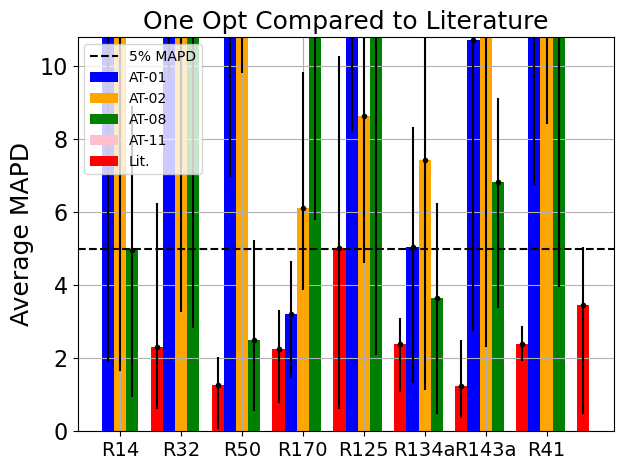

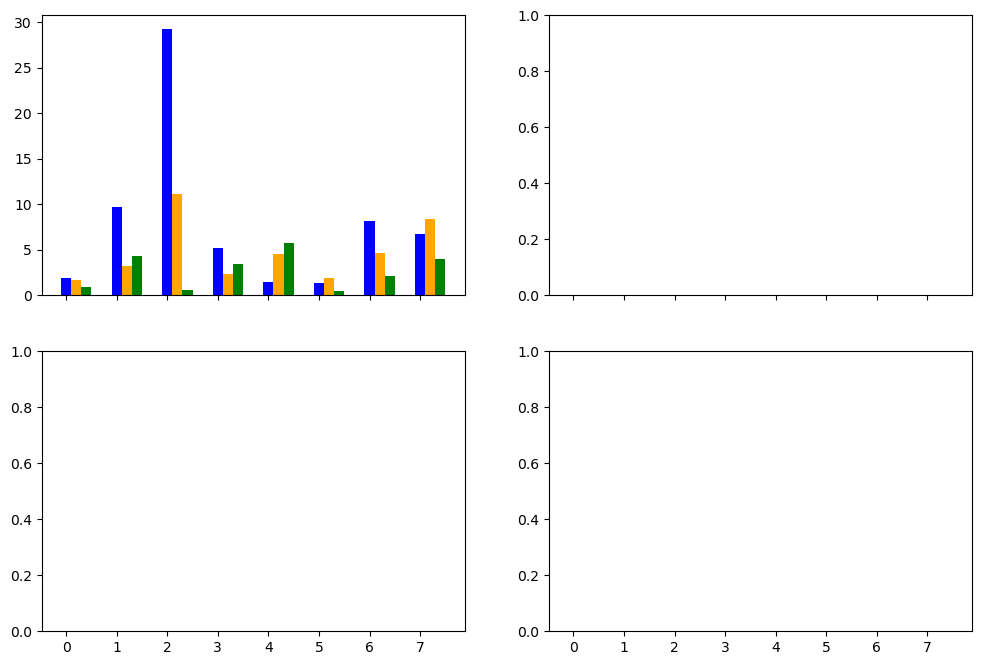

In [3]:
#Imports
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
import os
import copy
import scipy 
import signac
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpVal" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a", "R41"] #Training data to consider

#Get best_run data saved in one csv from all jobs
project = signac.get_project("opt_at_params")
#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)

def get_pref_theta(molec_names, at_number_list, obj_choices_list, old_list, which_list,  param_set):
    mapds_dfs = []

    for at_number, obj_choice, old, which, param in zip(at_number_list,obj_choices_list, old_list, which_list, param_set):
        visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)
        all_molec_dir = visual.use_dir_name #- "-R41"
        if obj_choice == "ExpValPrior":
            all_molec_dir = str(all_molec_dir).replace("-R41", "")
        if old:
            all_molec_dir = str(all_molec_dir).replace("Results", "Results-OldGP")
        try:
            if os.path.exists(os.path.join(all_molec_dir, "unique_best_set.csv")):
                path_best_sets = os.path.join(all_molec_dir, "unique_best_set.csv")
                all_df = pd.read_csv(path_best_sets, header = 0)
                first_param_name = visual.at_class.at_names[0]
                last_param_name = visual.at_class.at_names[-1]
                best_set = all_df.loc[param, first_param_name:last_param_name].values
            else:
                path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
                all_df = pd.read_csv(path_best_sets, header = 0)
                first_param_name = visual.at_class.at_names[0] + "_min"
                last_param_name = visual.at_class.at_names[-1] + "_min"
                best_set = all_df.loc[param, first_param_name:last_param_name].values
            best_real = visual.values_pref_to_real(copy.copy(best_set))
        except:
            best_real = None
        
        # mapds = visual.calc_MAPD_mimic_ms(molec_names, best_set)
        dfs = visual.calc_MAPD_best(molec_names, best_real)
        mapds_dfs.append(dfs[which])

    return mapds_dfs

at_schemes = [1, 2, 8,11,1]
# old_list = [False, False, False]
# objs = ["ExpValPrior", "ExpValPrior", "ExpValPrior"]
# which = ["Literature", "Opt_All", "Opt_All"]
# param_set = [0,0,1]
old_list = [False, False, False, False, False]
objs = ["ExpVal", "ExpVal", "ExpVal", "ExpValPrior", "ExpVal"]
which = ["Opt_All", "Opt_All", "Opt_All", "Opt_All", "Literature"]
param_set = [0,0,0,0,0]
mapd_dfs = get_pref_theta(molec_names, at_schemes, objs, old_list, which, param_set)
# df_labels = ["Literature", "5% eps_C1 Wt", "20% eps_C1 Wt"]
# df_colors = ["blue", "orange", "green"]
df_labels = ["AT-01", "AT-02", "AT-08", "AT-11", "Lit."]
df_colors = ["blue", "orange", "green", "pink", "red"]
title = "One Opt Compared to Literature"
visual.plot_avg_MAPD(mapd_dfs, df_labels, df_colors, title)
visual.plot_MAPD(mapd_dfs, df_labels, df_colors, title)

In [ ]:

#Imports
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
import os
import copy
import scipy 
import signac
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpValPrior" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"] #Training data to consider

#Get best_run data saved in one csv from all jobs
project = signac.get_project("opt_at_params")
#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)

#Set parameter set of interest (in this case get the best parameter set)
all_molec_dir = visual.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = visual.at_class.at_names[0] + "_min"
last_param_name = visual.at_class.at_names[-1] + "_min"
best_set = all_df.loc[0, first_param_name:last_param_name].values
# path_best_sets = os.path.join(all_molec_dir, "opt_params_rcc_best_set_1.csv")
# assert os.path.exists(path_best_sets), "opt_params_rcc_best_set_1.csv not found in directory"
# all_df = pd.read_csv(path_best_sets, header = 0)
# best_set = all_df.loc[:, visual.at_class.at_names].values
best_real = visual.values_pref_to_real(copy.copy(best_set))
x_label = "best_set"

# pdf = PdfPages('Results/at_schemes_' + at_str + '.pdf')
visual.calc_MAPD_best2(molec_names)
visual.plot_MSE_ind(molec_names, label = x_label)
# visual.plot_at_MSE(molec_names, at_schemes)
#Close figures 
# plt.close()
# pdf.close()   